In [6]:
import json
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [2]:
def json_to_expanded_df(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    def process_data(data):
        rows = []
        for backend, results in data.items():
            for key, count in results.items():
                split_data = key.split()  # Split based on space
                readout = int(split_data[0])  # L value (Z readout)
                bitstrings = split_data[1:]  # Remaining are the rounds
                
                # Flatten the bitstrings into individual bits
                expanded_bits = [int(bit) for bitstring in bitstrings for bit in bitstring]
                # Append backend, readout, and count
                rows.append([backend] + expanded_bits + [readout, count])

        return rows

    # Column names based on the description (Backend, Z Readout, X3_2 ... Z0_0, count)
    columns = [
        'backend',
        'X3_2', 'X2_2', 'X1_2', 'X0_2', 'Z3_2', 'Z2_2', 'Z1_2', 'Z0_2',
        'X3_1', 'X2_1', 'X1_1', 'X0_1', 'Z3_1', 'Z2_1', 'Z1_1', 'Z0_1',
        'X3_0', 'X2_0', 'X1_0', 'X0_0', 'Z3_0', 'Z2_0', 'Z1_0', 'Z0_0',
        'z_readout', 'count'
    ]

    return pd.DataFrame(process_data(data), columns=columns)

In [15]:
#df_3X = json_to_expanded_df('data/qubit3X_results.json')
name = 'qubit1Z_d3'
json_to_expanded_df(f'{name}_results.json').to_csv(f'{name}.csv', index=False)

In [17]:
#df = json_to_expanded_df('data/qubit1Z_results.json')
df = pd.read_csv(f'{name}.csv')
df

,backend,X3_2,X2_2,X1_2,X0_2,Z3_2,Z2_2,Z1_2,Z0_2,X3_1,...,X3_0,X2_0,X1_0,X0_0,Z3_0,Z2_0,Z1_0,Z0_0,z_readout,count
0,ibm_sherbrooke,0,0,1,0,0,1,0,1,0,...,1,1,0,0,0,1,1,1,1,1
1,ibm_sherbrooke,0,1,0,1,1,0,1,0,1,...,1,1,1,1,1,1,1,1,1,1
2,ibm_sherbrooke,1,0,1,0,0,1,0,0,0,...,0,1,1,0,0,1,1,1,0,1
3,ibm_sherbrooke,1,1,0,1,1,1,1,1,0,...,1,0,0,0,1,1,0,1,1,1
4,ibm_sherbrooke,0,1,0,0,0,1,1,1,0,...,0,0,0,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14991,ibm_brisbane,1,0,0,0,0,0,1,1,0,...,0,0,1,0,1,1,0,1,1,1
14992,ibm_brisbane,1,1,1,0,0,1,1,0,1,...,0,0,0,1,0,1,0,0,1,1
14993,ibm_brisbane,1,1,0,1,1,0,0,1,0,...,1,0,0,0,1,1,0,0,0,1
14994,ibm_brisbane,1,1,0,1,1,0,0,1,0,...,0,1,0,0,1,1,0,1,0,1


### New Features:
- `readout_match`: Binary feature; 1 if the logical readout (L) matches the expected readout, otherwise 0.
- `index_flip`: Eight columns (index_flip_0 to index_flip_7), representing the number of bit flips for each index between the three rounds.
- `agreement`: Proportion of bits that agree across all three rounds for each row.
- `flip_errs`: Count of the number of errors (1s) in the last four bits (Z3, Z2, Z1, Z0) of each round, where these bits should always be zero.

In [18]:
def json_to_expanded_df(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)

    def process_data(data):
        rows = []
        for backend, results in data.items():
            for key, count in results.items():
                split_data = key.split()  # Split based on space
                readout = int(split_data[0])  # L value (Z readout)
                bitstrings = split_data[1:]  # Remaining are the rounds
                
                # Flatten the bitstrings into individual bits
                expanded_bits = [int(bit) for bitstring in bitstrings for bit in bitstring]
                # Append backend, readout, and count
                rows.append([backend] + expanded_bits + [readout, count])

        return rows

    # Column names based on the description (Backend, Z Readout, X3_2 ... Z0_0, count)
    columns = [
        'backend',
        'X3_2', 'X2_2', 'X1_2', 'X0_2', 'Z3_2', 'Z2_2', 'Z1_2', 'Z0_2',
        'X3_1', 'X2_1', 'X1_1', 'X0_1', 'Z3_1', 'Z2_1', 'Z1_1', 'Z0_1',
        'X3_0', 'X2_0', 'X1_0', 'X0_0', 'Z3_0', 'Z2_0', 'Z1_0', 'Z0_0',
        'z_readout', 'count'
    ]

    return pd.DataFrame(process_data(data), columns=columns)
def calculate_index_flip(row):
    """Calculate the number of flips for each index between rounds."""
    flips = []
    rounds = [
        row[['X3_0', 'X2_0', 'X1_0', 'X0_0', 'Z3_0', 'Z2_0', 'Z1_0', 'Z0_0']].values,
        row[['X3_1', 'X2_1', 'X1_1', 'X0_1', 'Z3_1', 'Z2_1', 'Z1_1', 'Z0_1']].values,
        row[['X3_2', 'X2_2', 'X1_2', 'X0_2', 'Z3_2', 'Z2_2', 'Z1_2', 'Z0_2']].values
    ]
    for i in range(8):
        flips.append((rounds[0][i] != rounds[1][i]) + (rounds[1][i] != rounds[2][i]))
    return flips

def calculate_agreement(row):
    """Calculate the agreement between rounds for each bit."""
    agreement_count = 0
    rounds = [
        row[['X3_0', 'X2_0', 'X1_0', 'X0_0', 'Z3_0', 'Z2_0', 'Z1_0', 'Z0_0']].values,
        row[['X3_1', 'X2_1', 'X1_1', 'X0_1', 'Z3_1', 'Z2_1', 'Z1_1', 'Z0_1']].values,
        row[['X3_2', 'X2_2', 'X1_2', 'X0_2', 'Z3_2', 'Z2_2', 'Z1_2', 'Z0_2']].values
    ]
    for i in range(8):
        if rounds[0][i] == rounds[1][i] == rounds[2][i]:
            agreement_count += 1
    return agreement_count / 8  # Proportion of agreement

def calculate_flip_errs(row):
    """Calculate the number of errors (1s) in the last 4 bits of each round."""
    flip_errs = 0
    rounds = [
        row[['Z3_0', 'Z2_0', 'Z1_0', 'Z0_0']].values,
        row[['Z3_1', 'Z2_1', 'Z1_1', 'Z0_1']].values,
        row[['Z3_2', 'Z2_2', 'Z1_2', 'Z0_2']].values
    ]
    for round_bits in rounds:
        flip_errs += sum(round_bits)
    return flip_errs

def build_backend_classifier(df, expected_readout=1):
    df = df[df['backend'] != 'aer_simulator'].copy()  # Ensure we're working on a copy
    df = df[df['backend'] != 'ibm_kyoto'].copy() 
    
    # readout_match (1 if z_readout matches expected_readout, else 0)
    df.loc[:, 'readout_match'] = (df['z_readout'] == expected_readout).astype(int)
    
    # index_flip (how many times each index flips between rounds)
    index_flip_cols = ['index_flip_0', 'index_flip_1', 'index_flip_2', 'index_flip_3',
                       'index_flip_4', 'index_flip_5', 'index_flip_6', 'index_flip_7']
    df[index_flip_cols] = df.apply(calculate_index_flip, axis=1, result_type='expand')
    
    # agreement (proportion of bits that agree across rounds)
    df.loc[:, 'agreement'] = df.apply(calculate_agreement, axis=1)
    
    # flip_errs (count of errors in the last 4 bits of each round)
    df.loc[:, 'flip_errs'] = df.apply(calculate_flip_errs, axis=1)
    
    # Split the DataFrame into features (X) and target (y)
    X = df.drop(columns=['backend', 'count'])  # Features
    y = df['backend']  # Target
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create and train the RandomForestClassifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    # Predictions and evaluation
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Output accuracy and classification report
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf, df, y_test, y_pred

In [20]:
classifier, df, y_test, y_pred = build_backend_classifier(df)

Accuracy: 57.97%
Classification Report:
                precision    recall  f1-score   support

  ibm_brisbane       0.57      0.55      0.56      1476
      ibm_kyiv       0.61      0.66      0.63      1499
ibm_sherbrooke       0.55      0.53      0.54      1524

      accuracy                           0.58      4499
     macro avg       0.58      0.58      0.58      4499
  weighted avg       0.58      0.58      0.58      4499



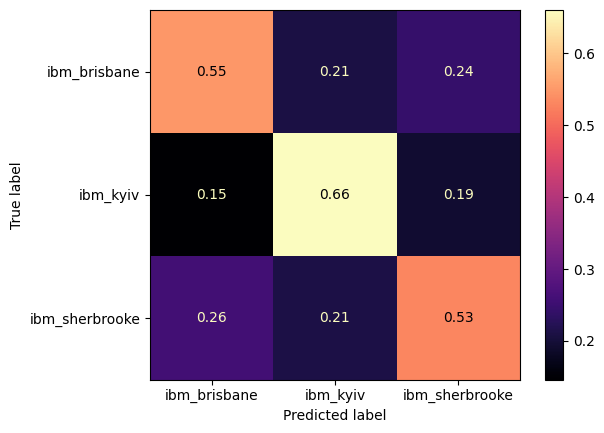

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')

In [47]:
# def generate_columns(distance):
#     """Generate column names dynamically based on the code distance."""
#     data_columns = [f'X{distance**2 - i}_{r}' for r in range(3) for i in range(distance**2)] + \
#                    [f'Z{(distance-1)**2 - i}_{r}' for r in range(3) for i in range((distance-1)**2)]
#     columns = ['backend'] + data_columns + ['z_readout', 'count']
#     return columns

# def process_data_dynamic(data, expected_bit_length):
#     """Process data dynamically based on the observed bit length."""
#     rows = []
    
#     for backend, results in data.items():
#         for key, count in results.items():
#             split_data = key.split()  # Split based on space
#             readout = int(split_data[0])  # Z readout value (L value)
#             bitstrings = split_data[1:]  # Remaining are the bitstrings
            
#             # Flatten the bitstrings into individual bits
#             expanded_bits = [int(bit) for bitstring in bitstrings for bit in bitstring]
            
#             # Verify the number of bits matches the expected bit length
#             if len(expanded_bits) != expected_bit_length * 3:  # 3 rounds of data
#                 raise ValueError(f"Expected {expected_bit_length * 3} bits, but got {len(expanded_bits)} bits.")
            
#             # Append backend, expanded bits (for all rounds), readout, and count
#             rows.append([backend] + expanded_bits + [readout, count])

#     return rows

# def calculate_index_flip_dynamic(row, distance):
#     """Calculate the number of flips for each index dynamically."""
#     flips = []
#     rounds = [
#         row[[f'X{distance**2 - i}_0' for i in range(distance**2)] +
#             [f'Z{distance**2 - i}_0' for i in range((distance-1)**2)]].values,
#         row[[f'X{distance**2 - i}_1' for i in range(distance**2)] +
#             [f'Z{distance**2 - i}_1' for i in range((distance-1)**2)]].values,
#         row[[f'X{distance**2 - i}_2' for i in range(distance**2)] +
#             [f'Z{distance**2 - i}_2' for i in range((distance-1)**2)]].values
#     ]
#     total_bits = distance**2 + (distance-1)**2
#     for i in range(total_bits):
#         flips.append((rounds[0][i] != rounds[1][i]) + (rounds[1][i] != rounds[2][i]))
#     return flips

# def calculate_agreement_dynamic(row, distance):
#     """Calculate agreement proportion dynamically based on distance."""
#     agreement_count = 0
#     rounds = [
#         row[[f'X{distance**2 - i}_0' for i in range(distance**2)] +
#             [f'Z{distance**2 - i}_0' for i in range((distance-1)**2)]].values,
#         row[[f'X{distance**2 - i}_1' for i in range(distance**2)] +
#             [f'Z{distance**2 - i}_1' for i in range((distance-1)**2)]].values,
#         row[[f'X{distance**2 - i}_2' for i in range(distance**2)] +
#             [f'Z{distance**2 - i}_2' for i in range((distance-1)**2)]].values
#     ]
#     total_bits = distance**2 + (distance-1)**2
#     for i in range(total_bits):
#         if rounds[0][i] == rounds[1][i] == rounds[2][i]:
#             agreement_count += 1
#     return agreement_count / total_bits

# def calculate_flip_errs_dynamic(row, distance):
#     """Calculate the number of errors in the last few bits dynamically."""
#     flip_errs = 0
#     rounds = [
#         row[[f'Z{distance**2 - i}_0' for i in range((distance-1)**2)]].values,
#         row[[f'Z{distance**2 - i}_1' for i in range((distance-1)**2)]].values,
#         row[[f'Z{distance**2 - i}_2' for i in range((distance-1)**2)]].values
#     ]
#     for round_bits in rounds:
#         flip_errs += sum(round_bits)
#     return flip_errs

# def build_backend_classifier_dynamic(df, distance, expected_readout=1):
#     df = df[df['backend'] != 'aer_simulator'].copy()  # Ensure we're working on a copy
#     df = df[df['backend'] != 'ibm_kyoto'].copy()
    
#     # Readout match (1 if z_readout matches expected_readout, else 0)
#     df.loc[:, 'readout_match'] = (df['z_readout'] == expected_readout).astype(int)
    
#     # Index flip (how many times each index flips between rounds)
#     index_flip_cols = [f'index_flip_{i}' for i in range(distance**2 + (distance-1)**2)]
#     df[index_flip_cols] = df.apply(calculate_index_flip_dynamic, axis=1, result_type='expand', distance=distance)
    
#     # Agreement (proportion of bits that agree across rounds)
#     df.loc[:, 'agreement'] = df.apply(calculate_agreement_dynamic, axis=1, distance=distance)
    
#     # Flip errors (count of errors in the last bits)
#     df.loc[:, 'flip_errs'] = df.apply(calculate_flip_errs_dynamic, axis=1, distance=distance)
    
#     # Split the DataFrame into features (X) and target (y)
#     X = df.drop(columns=['backend', 'count'])  # Features
#     y = df['backend']  # Target
    
#     # Split data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
#     # Create and train the RandomForestClassifier
#     clf = RandomForestClassifier(random_state=42)
#     clf.fit(X_train, y_train)
    
#     # Predictions and evaluation
#     y_pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
    
#     # Output accuracy and classification report
#     print(f"Accuracy: {accuracy * 100:.2f}%")
#     print("Classification Report:")
#     print(classification_report(y_test, y_pred))
    
#     return clf, df, y_test, y_pred


In [71]:
def json_to_expanded_df(json_file, d = 5, num_rounds = 3):
    with open(json_file, 'r') as f:
        data = json.load(f)

    def process_data(data):
        rows = []
        for backend, results in data.items():
            for key, count in results.items():
                split_data = key.split()  # Split based on space
                readout = int(split_data[0])  # L value (Z readout)
                bitstrings = split_data[1:]  # Remaining are the rounds

                # Flatten the bitstrings into individual bits
                expanded_bits = [int(bit) for bitstring in bitstrings for bit in bitstring]
                
                # Append backend, expanded bits, readout, and count
                rows.append([backend] + expanded_bits + [readout, count])

        return rows

    # Dynamically generate column names based on the bitstring length
    num_bits_per_round = (d*d)-1  # 24 bits per round as per the data

    columns = ['backend']
    for r in range(num_rounds):
        for q in range(num_bits_per_round):
            columns.append(f'bit_{q}_round_{r}')

    columns += ['z_readout', 'count']

    # Debugging: Print expected number of columns
    print(f"Total expected columns: {len(columns)}")

    return pd.DataFrame(process_data(data), columns=columns)

def calculate_index_flip(row):
    """Calculate the number of flips for each bit between rounds."""
    flips = []
    
    # Iterate through the 24 bits (since each round has 24 bits)
    for i in range(24):
        # Check flips between round_0, round_1, and round_2
        bit_r0 = row[f'bit_{i}_round_0']
        bit_r1 = row[f'bit_{i}_round_1']
        bit_r2 = row[f'bit_{i}_round_2']
        
        # Count the flips between consecutive rounds
        flip_count = (bit_r0 != bit_r1) + (bit_r1 != bit_r2)
        flips.append(flip_count)
    
    return flips

def calculate_agreement(row):
    """Calculate the agreement between rounds for each bit."""
    agreement_count = 0

    # Iterate through the 24 bits and check if they agree across rounds
    for i in range(24):
        bit_r0 = row[f'bit_{i}_round_0']
        bit_r1 = row[f'bit_{i}_round_1']
        bit_r2 = row[f'bit_{i}_round_2']
        
        # Check if the bits are the same in all rounds
        if bit_r0 == bit_r1 == bit_r2:
            agreement_count += 1

    return agreement_count / 24  # Proportion of agreement

def calculate_flip_errs(row):
    """Calculate the number of errors (1s) in the last 4 bits of each round."""
    flip_errs = 0

    # Iterate through the last 4 bits (bit_20 to bit_23) for each round
    for i in range(20, 24):
        flip_errs += row[f'bit_{i}_round_0']
        flip_errs += row[f'bit_{i}_round_1']
        flip_errs += row[f'bit_{i}_round_2']
    
    return flip_errs

def build_backend_classifier(df, expected_readout=0):
    df = df[df['backend'] != 'aer_simulator'].copy()  # Ensure we're working on a copy
    df = df[df['backend'] != 'ibm_kyoto'].copy() 
    
    # readout_match (1 if z_readout matches expected_readout, else 0)
    df['readout_match'] = (df['z_readout'] == expected_readout).astype(int)
    
    # index_flip (how many times each bit flips between rounds)
    index_flip_cols = [f'index_flip_{i}' for i in range(24)]
    df[index_flip_cols] = df.apply(calculate_index_flip, axis=1, result_type='expand')
    
    # agreement (proportion of bits that agree across rounds)
    df['agreement'] = df.apply(calculate_agreement, axis=1)
    
    # flip_errs (count of errors in the last 4 bits of each round)
    df['flip_errs'] = df.apply(calculate_flip_errs, axis=1)
    
    # Select features for training (excluding backend and count)
    X = df.drop(columns=['backend', 'count'])
    y = df['backend']  # Target
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create and train the RandomForestClassifier
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    # Predictions and evaluation
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Output accuracy and classification report
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return clf, df, y_test, y_pred


In [74]:
json_file = 'qubit1Z_d5_results.json'

df = json_to_expanded_df(json_file)

Total expected columns: 75


In [67]:
df.columns

Index(['backend', 'bit_0_round_0', 'bit_1_round_0', 'bit_2_round_0',
       'bit_3_round_0', 'bit_4_round_0', 'bit_5_round_0', 'bit_6_round_0',
       'bit_7_round_0', 'bit_8_round_0', 'bit_9_round_0', 'bit_10_round_0',
       'bit_11_round_0', 'bit_12_round_0', 'bit_13_round_0', 'bit_14_round_0',
       'bit_15_round_0', 'bit_16_round_0', 'bit_17_round_0', 'bit_18_round_0',
       'bit_19_round_0', 'bit_20_round_0', 'bit_21_round_0', 'bit_22_round_0',
       'bit_23_round_0', 'bit_0_round_1', 'bit_1_round_1', 'bit_2_round_1',
       'bit_3_round_1', 'bit_4_round_1', 'bit_5_round_1', 'bit_6_round_1',
       'bit_7_round_1', 'bit_8_round_1', 'bit_9_round_1', 'bit_10_round_1',
       'bit_11_round_1', 'bit_12_round_1', 'bit_13_round_1', 'bit_14_round_1',
       'bit_15_round_1', 'bit_16_round_1', 'bit_17_round_1', 'bit_18_round_1',
       'bit_19_round_1', 'bit_20_round_1', 'bit_21_round_1', 'bit_22_round_1',
       'bit_23_round_1', 'bit_0_round_2', 'bit_1_round_2', 'bit_2_round_2',
   

In [72]:
# Assuming df is already created from json_to_expanded_df
clf, updated_df, y_test, y_pred = build_backend_classifier(df, expected_readout=1)

Accuracy: 76.31%
Classification Report:
                precision    recall  f1-score   support

  ibm_brisbane       0.74      0.69      0.71      1492
      ibm_kyiv       0.80      0.83      0.81      1484
ibm_sherbrooke       0.75      0.77      0.76      1524

      accuracy                           0.76      4500
     macro avg       0.76      0.76      0.76      4500
  weighted avg       0.76      0.76      0.76      4500



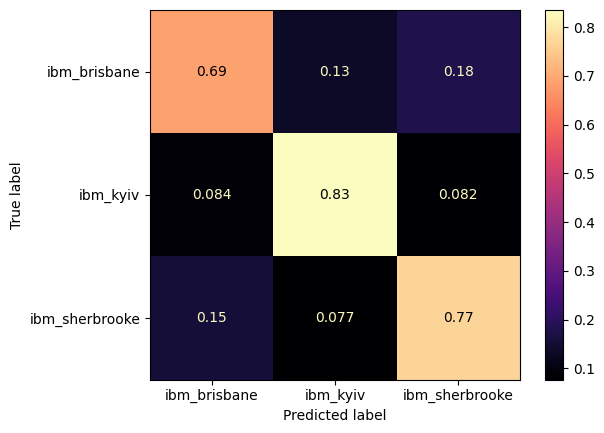

In [73]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='magma', normalize='true')

- increase # of mappings to classify
- classify based on "older" transpilations / qpys
- change to binary classification
- mappings would only matter for qPuf, train one classifier per mapping

- rerun saved transpilations from d=5 tomorrow, next week
- implement arbitrary mapping?
- generate confusion matrix across machines and mappings
- gernerate a new classifier per mapping => you expect to know which mapping you're working with
    - pull the classifier that you generated for that backend & mapping
    - ex: have brisbane mapping a, everything is labeled as brisbane_a or not

```python
for backend in backends:
    for mapping_label in ["a", "b", "c"]:
        random_layout = np.random.permutation(backend.num_qubits)[
            : qc.num_qubits
        ]
        qc_transpiled = transpile(qc, backend, initial_layout=random_layout)
```